In [1]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field

OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType]

## We use these schemas to prompt the LLM to generate equations that evaluate to 24.


class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24."""

    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


class GuessEquations(BaseModel):
    """Submit multiple equations as guesses."""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description="The list of equations to submit as guesses."
    )


## These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# You can update the candidate object to match your own task.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

In [2]:
import requests
import csv

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
).partial(candidate="")
llm = ChatOpenAI(model="gpt-4o-mini")

bound_llm = llm.with_structured_output(GuessEquations)
solver = prompt | bound_llm

In [4]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]
    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate, score=score, feedback=feedback
        )
    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"
    return ScoredCandidate(
        candidate=candidate.candidate, score=score, feedback=feedback
    )

In [5]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph

from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]


class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 0.9),
        "k": configurable.get("k", 5),
        "beam_size": configurable.get("beam_size", 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]


def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
    """Generate the next state."""
    configurable = _ensure_configurable(config)
    if not state.get("seed"):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state["seed"])
    try:
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": configurable["k"],
            },
            config=config,
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}


def score(state: ToTState) -> Dict[str, List[float]]:
    """Evaluate the candidate generations."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}


def prune(
    state: ToTState, *, config: RunnableConfig
) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate[1], reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # Update the starting point for the next iteration
        "candidates": pruned,
        # Clear the old memory
        "scored_candidates": "clear",
        # Increment the depth by 1
        "depth": 1,
    }


def should_terminate(
    state: ToTState, config: RunnableConfig
) -> Union[Literal["__end__"], Send]:
    configurable = _ensure_configurable(config)
    solved = state["candidates"][0].score >= configurable["threshold"]
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    return [
        Send("expand", {**state, "somevalseed": candidate})
        for candidate in state["candidates"]
    ]


# Create the graph
builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# Set entry point
builder.add_edge("__start__", "expand")

# Compile the graph
graph = builder.compile(checkpointer=MemorySaver())

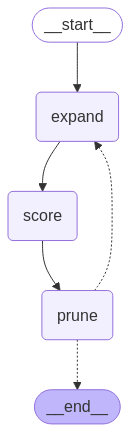

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {
    "configurable": {
        "thread_id": "test_1",
        "depth": 10,
    }
}
for step in graph.stream({"problem": puzzles[42]}, config):
    print(step)

{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[12.0, 7.0, '*', -1.0, 5.0, '+', '-', 1.0, '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 5.0, '*', 7.0, '-', '-', '/', 1.0, '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[1.0, 12.0, '*', 5.0, '-', '-', 7.0, '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[7.0, 5.0, '*', 1.0, '-', '/', 6.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 1.0, '*', 5.0, '+', 7.0, '-']), score=None, feedback=None)]}}
{'score': {'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[12.0, 7.0, '*', -1.0, 5.0, '+', '-', 1.0, '*']), score=0, feedback='The equation must use all 4 numbers exactly once.'), ScoredCandidate(candidate=Equation(tokens=[12.0, 5.0, '*', 7.0, '-', '-', '/', 1.0, '+']), score=0, feedback="Invalid equation. Error: IndexError('pop from empty list')"), ScoredCandidate(candidate=Equation(tokens=[1.0, 12.0, '*'

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai.llms import OpenAI
from langchain_ollama.llms import OllamaLLM
from langchain_ollama.chat_models import ChatOllama
import os


template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

deepseek_model = ChatOllama(
    model="deepseek-r1:70b", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
llama3_model = ChatOllama(
    model="llama3.3:70b", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
gpt_model = ChatOpenAI(temperature=1, model="gpt-4o-mini")

# chain = prompt | gpt_model

# for toen in chain.stream({"question": "Whast is LangChain?"}):
#     print(toen, end="")

In [354]:
class Configuration(TypedDict, total=False):
    max_depth: int
    max_candidates: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 5),
        "max_candidates": configurable.get("max_candidates", 2),
    }

In [355]:
from langchain_core.runnables import Runnable
from typing import TypedDict
from pydantic import BaseModel
from abstract_agent import Agent
from langchain_core.prompts import PromptTemplate
from langgraph.graph import MessagesState, START, END
from operator import add

llm = gpt_model


class CoTState(MessagesState):
    steps: Annotated[list[str], add]
    last_step: bool


class ThoughtSchema(BaseModel):
    thought: str
    finish: bool


thinker_template = """
{{ system_prompt }}.

Before executing the task, think deeply about the next step to solve the task given by the user.
The tought you will give is the step of how to complete given by the user task.
The purpose of the thoughts is to break the problem into smaller steps.
Already taken steps: 
{% if steps %}{{ steps }}{% else %}This is your first step to solve this problem.{% endif %}

What is the next step to solve this problem? Is it the last step thast must be taken to complete the task?
Return only the next step in one sentence.
"""

thinker_prompt = PromptTemplate(
    template=thinker_template,
    input_variables=["system_prompt", "steps"],
    template_format="jinja2",
)

system_prompt = "You are helpful code assistant."


def reasoning_node(state: CoTState) -> CoTState:
    system_prompt = "Your system prompt here"
    if "steps" in state and state["steps"]:
        formatted_prompt = thinker_prompt.format(
            system_prompt=system_prompt,
            steps="\n".join(
                [f"{n+1}. {step}" for n, step in enumerate(state["steps"])]
            ),
        )
    else:
        formatted_prompt = thinker_prompt.format(system_prompt=system_prompt)

    print(formatted_prompt)

    thought = (
        llm.with_structured_output(ThoughtSchema)
        .invoke([("system", formatted_prompt), state["messages"][-1]])
        .model_dump()
    )

    return {
        "steps": [thought["thought"]],
        "last_step": thought["finish"],
    }


def should_continue(
    state: CoTState, config: RunnableConfig
) -> Literal["reasoning_node", "__end__"]:
    max_depth = _ensure_configurable(config).get("max_depth")
    if state["last_step"] or len(state["steps"]) >= max_depth:
        return "__end__"
    return "reasoning_node"


class CoTAgent(Agent):
    def __init__(self, llm: Runnable, system_prompt: str):
        self.llm = llm
        self.system_prompt = system_prompt

    def invoke(self):
        # self.llm.invoke([
        #     ("system", "")
        # ])
        pass

In [356]:
graph_builder = StateGraph(CoTState, config_schema=Configuration)

graph_builder.add_node("reasoning_node", reasoning_node)

graph_builder.add_edge(START, "reasoning_node")
graph_builder.add_conditional_edges(
    "reasoning_node", should_continue, ["reasoning_node", "__end__"]
)
graph = graph_builder.compile()

In [357]:
graph.invoke(
    {"messages": [("user", "Create pacman game in python")]}, config={"max_depth": 10}
)


Your system prompt here.

Before executing the task, think deeply about the next step to solve the task given by the user.
The tought you will give is the step of how to complete given by the user task.
The purpose of the thoughts is to break the problem into smaller steps.
Already taken steps: 
This is your first step to solve this problem.

What is the next step to solve this problem? Is it the last step thast must be taken to complete the task?
Return only the next step in one sentence.

Your system prompt here.

Before executing the task, think deeply about the next step to solve the task given by the user.
The tought you will give is the step of how to complete given by the user task.
The purpose of the thoughts is to break the problem into smaller steps.
Already taken steps: 
1. Break down the creation of the Pacman game into smaller tasks, starting with setting up the game window using a library like Pygame.

What is the next step to solve this problem? Is it the last step thas

{'messages': [HumanMessage(content='Create pacman game in python', additional_kwargs={}, response_metadata={}, id='8d50ce82-15d4-43fd-a593-b6d135d32887')],
 'steps': ['Break down the creation of the Pacman game into smaller tasks, starting with setting up the game window using a library like Pygame.',
  'Implement the main game loop that will handle events, update game state, and redraw the game frame.',
  "Implement the player character's movement and collision detection with walls and dots within the game loop.",
  "Implement the ghosts' AI behavior and their movement patterns, ensuring they interact properly with the player character and the game environment.",
  "Implement the scoring system that tracks the player's score as they collect dots and incorporates game over conditions when the player is caught by a ghost.",
  'Implement levels and additional features such as power-ups or multiple levels to enhance gameplay after the scoring system is in place.',
  'Test and refine the g

In [557]:
class TreeNode:
    def __init__(self, thought, finish=False, score=None):
        self.thought = thought
        self.finish = finish
        self.score = score
        self.children = []

    def add_child(self, thought, finish=False, score=None):
        """Add a child node with the given thought, finish status, and score"""
        child = TreeNode(thought, finish, score)
        self.children.append(child)
        return child

    def remove_child(self, thought):
        """Remove a direct child node with the given thought"""
        for i, child in enumerate(self.children):
            if child.thought == thought:
                return self.children.pop(i)
        return None

    def __str__(self, level=0):
        """String representation of the node and its children with indentation"""
        score_str = f", score: {self.score}" if self.score is not None else ""
        result = (
            "  " * level
            + f"{{thought: '{self.thought}', finish: {self.finish}{score_str}}}\n"
        )
        for child in self.children:
            result += child.__str__(level + 1)
        return result

    def is_leaf(self):
        """Check if the node is a leaf node (has no children)"""
        return len(self.children) == 0


class ThoughtTree:
    def __init__(self, root_thought="Root", root_score=None):
        """Initialize the tree with a root node"""
        self.root = TreeNode(root_thought, score=root_score)

    def find_node(self, thought, node=None):
        """Find a node with the given thought"""
        if node is None:
            node = self.root

        if node.thought == thought:
            return node

        for child in node.children:
            result = self.find_node(thought, child)
            if result:
                return result

        return None

    def find_parent(self, thought, node=None, parent=None):
        """Find the parent of a node with the given thought"""
        if node is None:
            node = self.root

        # Check if any of this node's children match the target
        for child in node.children:
            if child.thought == thought:
                return node

        # Recursively check all children
        for child in node.children:
            result = self.find_parent(thought, child, node)
            if result:
                return result

        return None

    def add_thought(self, parent_thought, new_thought, finish=False, score=None):
        """Add a thought node as a child of the parent thought node with optional score"""
        parent = self.find_node(parent_thought)
        if parent:
            return parent.add_child(new_thought, finish, score)
        else:
            raise ValueError(f"Parent thought '{parent_thought}' not found in the tree")

    def set_score(self, thought, score):
        """Set the score for a node"""
        node = self.find_node(thought)
        if node:
            node.score = score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_score(self, thought):
        """Get the score for a node"""
        node = self.find_node(thought)
        if node:
            return node.score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_highest_scoring_nodes(self, count=1):
        """Return the highest scoring nodes"""
        nodes_with_scores = []

        def collect_scored_nodes(node):
            if node.score is not None:
                nodes_with_scores.append((node.thought, node.score))
            for child in node.children:
                collect_scored_nodes(child)

        collect_scored_nodes(self.root)
        # Sort by score in descending order
        sorted_nodes = sorted(nodes_with_scores, key=lambda x: x[1], reverse=True)
        return sorted_nodes[:count]

    def remove_node(self, thought, preserve_children=True):
        """
        Remove a node from the tree

        Args:
            thought: The thought content of the node to remove
            preserve_children: If True, the children of the removed node
                              will be attached to the parent of the removed node.
                              If False, the entire subtree will be removed.

        Returns:
            The removed node
        """
        # Cannot remove the root node
        if thought == self.root.thought:
            raise ValueError("Cannot remove the root node")

        # Find the parent of the node to remove
        parent = self.find_parent(thought)
        if not parent:
            raise ValueError(f"Thought '{thought}' not found in the tree")

        # Find the node to remove
        node_to_remove = None
        for i, child in enumerate(parent.children):
            if child.thought == thought:
                node_to_remove = parent.children.pop(i)
                break

        # If we want to preserve the children, attach them to the parent
        if preserve_children and node_to_remove:
            for child in node_to_remove.children:
                parent.children.append(child)

        return node_to_remove

    def mark_as_finished(self, thought):
        """Mark a thought node as finished"""
        node = self.find_node(thought)
        if node:
            node.finish = True
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_leaf_nodes(self):
        """Return all leaf nodes (nodes with no children)"""
        leaves = []

        def collect_leaves(node):
            if node.is_leaf():
                leaf_data = {"thought": node.thought, "finish": node.finish}
                if node.score is not None:
                    leaf_data["score"] = node.score
                leaves.append(leaf_data)
            else:
                for child in node.children:
                    collect_leaves(child)

        collect_leaves(self.root)
        return leaves

    def get_all_paths(self):
        """Return all paths from root to each leaf node or finished node"""
        all_paths = []

        def dfs(node, current_path):
            # Add current node to the path
            node_data = {"thought": node.thought, "finish": node.finish}
            if node.score is not None:
                node_data["score"] = node.score
            current_path.append(node_data)

            # If it's a leaf node or a finished node, add the path to all_paths
            if node.is_leaf() or node.finish:
                all_paths.append(current_path.copy())

            # Continue DFS for each child
            for child in node.children:
                dfs(child, current_path.copy())

        # Start DFS from root
        dfs(self.root, [])
        return all_paths

    def get_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [path for path in all_paths if path[-1]["finish"]]

    def get_not_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [
            path
            for path in all_paths
            if not path[-1]["finish"] or "score" not in path[-1]
        ]

    def are_all_paths_finished(self):
        return len(self.get_all_paths()) == len(self.get_finished_paths())

    def get_highest_scoring_path(self):
        """Return the path with the highest cumulative score"""
        all_paths = self.get_all_paths()

        if not all_paths:
            return None

        # Calculate sum of scores for each path (ignoring nodes without scores)
        path_scores = []
        for path in all_paths:
            total_score = sum(node.get("score", 0) for node in path)
            path_scores.append((path, total_score))

        # Return the path with the highest total score
        return max(path_scores, key=lambda x: x[1])

    def __str__(self):
        """String representation of the entire tree"""
        return str(self.root)


# Example usage
if __name__ == "__main__":
    # Create a tree
    tree = ThoughtTree("Initial problem", root_score=5)

    # Add some thoughts with scores
    tree.add_thought("Initial problem", "Try approach A", score=7)
    tree.add_thought("Initial problem", "Try approach B", score=4)
    tree.add_thought("Try approach A", "Solution 1", finish=True, score=9)
    tree.add_thought("Try approach B", "Obstacle encountered", score=3)
    tree.add_thought("Obstacle encountered", "Solution 2", finish=True, score=8)
    tree.add_thought("Obstacle encountered", "Alternative path", score=5)

    # Print the tree with scores
    print("Tree structure with scores:")
    print(tree)

    # Set a score for an existing node
    tree.set_score("Alternative path", 6)

    # Get a node's score
    print(f"\nScore for 'Solution 1': {tree.get_score('Solution 1')}")

    # Get highest scoring nodes
    print("\nTop 3 highest scoring nodes:")
    for thought, score in tree.get_highest_scoring_nodes(count=3):
        print(f"  {thought}: {score}")

    # Get path with highest cumulative score
    best_path, best_score = tree.get_highest_scoring_path()
    print(f"\nPath with highest cumulative score (total: {best_score}):")
    for node in best_path:
        score_str = f" (score: {node.get('score', 'None')})" if "score" in node else ""
        print(f"  {node['thought']}{score_str}")

Tree structure with scores:
{thought: 'Initial problem', finish: False, score: 5}
  {thought: 'Try approach A', finish: False, score: 7}
    {thought: 'Solution 1', finish: True, score: 9}
  {thought: 'Try approach B', finish: False, score: 4}
    {thought: 'Obstacle encountered', finish: False, score: 3}
      {thought: 'Solution 2', finish: True, score: 8}
      {thought: 'Alternative path', finish: False, score: 5}


Score for 'Solution 1': 9

Top 3 highest scoring nodes:
  Solution 1: 9
  Solution 2: 8
  Try approach A: 7

Path with highest cumulative score (total: 21):
  Initial problem (score: 5)
  Try approach A (score: 7)
  Solution 1 (score: 9)


In [ ]:
class ToTState(MessagesState):
    tree: ThoughtTree
    propositions: list[ThoughtSchema]
    goal: str
    depth: Annotated[int, add]


def create_goal(state: ToTState) -> ToTState:
    output = llm.invoke(
        [
            (
                "system",
                "State the goal of the user. In one short sentece. Tell what is the user intention.",
            ),
            state["messages"][-1],
        ]
    ).content
    return {"goal": output}


def reasoning_node(state: ToTState) -> ToTState:
    if "tree" in state and state["tree"]:
        propositions = []
        for path in state["tree"].get_not_finished_paths():
            formatted_prompt = thinker_prompt.format(
                system_prompt=system_prompt,
                steps="\n".join(
                    [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
                ),
            )
            prompts = [
                [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
            ]
            thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
            thoughts = [t.model_dump() for t in thoughts]
            propositions.append(thoughts)

        return {"propositions": propositions, "depth": 1}
    else:
        formatted_prompt = thinker_prompt.format(system_prompt=system_prompt)
        prompts = [
            [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
        ]

        thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
        thoughts = [t.model_dump() for t in thoughts]

        return {"propositions": [thoughts], "depth": 0}


def build_tree(state: ToTState) -> ToTState:
    propositions = state.get("propositions", [[]])
    tree = state.get("tree", ThoughtTree(state["goal"]))
    for leaf, propositions_for_leaf in zip(tree.get_leaf_nodes(), propositions):
        for prop in propositions_for_leaf:
            tree.add_thought(leaf["thought"], prop["thought"], prop["finish"])
    return {"tree": tree, "depth": 0}


def score_and_prune(state: ToTState, config: RunnableConfig) -> ToTState:
    class Scores(BaseModel):
        score: int
        reason: str

    tree = state["tree"]
    config = _ensure_configurable(config)
    system_prompt = (
        "Your task is to critisize the plan for achieving given goal."
        "Assign points from 1 to 10."
    )
    prompts = []
    paths = tree.get_not_finished_paths()

    for path in paths:
        steps = "\n".join(
            [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
        )
        prompts.append(
            [
                ("system", system_prompt),
                (
                    "user",
                    "Goal: "
                    "{goal} \n"
                    "Plan:"
                    "{plan}".format(goal=state["goal"], plan=steps),
                ),
            ]
        )
    scores = llm.with_structured_output(Scores).batch(prompts)
    scores = [s.model_dump()["score"] for s in scores]

    paths_scores = list(zip(paths, scores))
    paths_scores_sorted = list(sorted(paths_scores, key=lambda x: x[-1], reverse=True))

    for path, score in paths_scores_sorted[: config.get("max_candidates")]:
        tree.set_score(path[-1]["thought"], score)

    for path, _ in paths_scores_sorted[config.get("max_candidates") :]:
        tree.remove_node(path[-1]["thought"])

    return {"tree": tree, "depth": 0}


def should_continue(
    state: ToTState, config: Configuration
) -> Literal["__end__", "reasoning_node"]:
    config = _ensure_configurable(config)
    if state["tree"].are_all_paths_finished() or state["depth"] >= config.get(
        "max_depth"
    ):
        return "__end__"
    return "reasoning_node"

In [569]:
graph_builder = StateGraph(ToTState, config_schema=Configuration)

graph_builder.add_node("create_goal", create_goal)
graph_builder.add_node("reasoning_node", reasoning_node)
graph_builder.add_node("build_tree", build_tree)
graph_builder.add_node("score_and_prune", score_and_prune)

graph_builder.add_edge(START, "create_goal")
graph_builder.add_edge("create_goal", "reasoning_node")
graph_builder.add_edge("reasoning_node", "build_tree")
graph_builder.add_edge("build_tree", "score_and_prune")
graph_builder.add_conditional_edges(
    "score_and_prune", should_continue, ["__end__", "reasoning_node"]
)

tot_graph = graph_builder.compile()

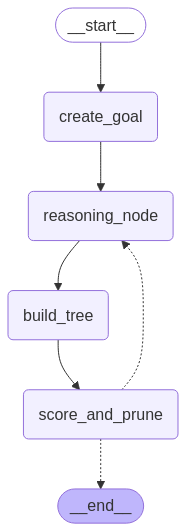

In [570]:
from IPython.display import Image, display

display(Image(tot_graph.get_graph().draw_mermaid_png()))

In [571]:
tot_graph.invoke(
    {"messages": [("user", "Create a game in packman")]}, config={"max_depth": 5}
)

{thought: 'The user intends to design or develop a game inspired by Pac-Man.', finish: False}
  {thought: 'Define the game mechanics, including player movement, point collection, and enemy behavior for the Pacman game.', finish: False, score: 6}
  {thought: 'Define the core mechanics of the Pac-Man game, such as player movement, ghost AI, and how points are scored by eating pellets and fruits.', finish: False, score: 7}

PATH
PATH
{thought: 'The user intends to design or develop a game inspired by Pac-Man.', finish: False}
  {thought: 'Define the game mechanics, including player movement, point collection, and enemy behavior for the Pacman game.', finish: False, score: 6}
    {thought: 'Develop the game environment by designing the maze layout and implementing the graphics for the Pac-Man character, dots, and enemies.', finish: False, score: 6}
    {thought: 'Develop a game design document that outlines the graphics, levels, power-ups, and scoring system necessary for implementing the 

{'messages': [HumanMessage(content='Create a game in packman', additional_kwargs={}, response_metadata={}, id='2b5ad40f-afef-41f1-a3b6-f859262533f0')],
 'tree': <__main__.ThoughtTree at 0x1181ac2f0>,
 'propositions': [[{'thought': 'Begin by defining the specific game mechanics, such as how the player controls the Pac-Man character, the behaviors of the ghosts, and the rules for collecting items and scoring points.',
    'finish': False},
   {'thought': 'The next step is to brainstorm and outline the specific features and unique twists you want to implement in your version of the Pac-Man game to differentiate it from the classic version.',
    'finish': False},
   {'thought': 'Begin developing the gameplay by defining the controls for player movement, item collection mechanics, and enemy AI behavior.',
    'finish': False},
   {'thought': 'Begin by brainstorming and sketching out the game mechanics, such as how the player will move through the maze, collect points, and interact with ene

In [572]:
state = _

In [ ]:
state["tree"].get_highest_scoring_path()

([{'thought': 'The user intends to design or develop a game inspired by Pac-Man.',
   'finish': False},
  {'thought': 'Define the game mechanics, including player movement, point collection, and enemy behavior for the Pacman game.',
   'finish': False,
   'score': 6},
  {'thought': 'Develop the game environment by designing the maze layout and implementing the graphics for the Pac-Man character, dots, and enemies.',
   'finish': False,
   'score': 6},
  {'thought': 'Implement the game logic, including collision detection, scoring system, and win/lose conditions.',
   'finish': False,
   'score': 7},
  {'thought': 'Test the game extensively to identify and fix any bugs, optimize performance, and ensure a smooth user experience before the final release.',
   'finish': False,
   'score': 8},
  {'thought': 'Prepare a marketing strategy for the final release of the game, including promotional materials, social media outreach, and potential partnerships.',
   'finish': False,
   'score': 8},